**Persian Data**

---



**Install hazm**

In [1]:
!pip install hazm

**Import library**

In [2]:
from hazm import Normalizer, sent_tokenize, word_tokenize, stopwords_list, Lemmatizer
import re
import string

**Read file**

In [3]:
with open('/content/hp_fa.txt', 'r', encoding='utf-8') as file:
    text_fa = file.read()

**Delete extra blank space**

In [4]:
text_fa = re.sub(r'\s+', ' ', text_fa)
text_fa = ' '.join(text_fa.split())

**Parse into sentences**

In [5]:
sentences = sent_tokenize(text_fa)

**Normalize**

In [6]:
normalizer = Normalizer()
normalized_sentences = [normalizer.normalize(sentence) for sentence in sentences]

**Tokenize sentences into words**

In [7]:
words = [word_tokenize(sentence) for sentence in sentences]

**Remove punctuation**

In [8]:
cleaned_words = [[re.sub(f'[{string.punctuation}؟،٪×÷»«]+', '', word) for word in sublist_word] for sublist_word in words]
cleaned_words = [[word for word in sublist_word if word] for sublist_word in cleaned_words] # remove empty str after removing punctuation

**Remove Stopwords**

In [9]:
cleaned_words = [[word for word in sublist_word if word not in stopwords_list()] for sublist_word in cleaned_words]

**Remove emoji**

In [12]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\u2764\uFE0F"           # red heart
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

cleaned_words = [[deEmojify(word) for word in sublist_word] for sublist_word in cleaned_words if sublist_word]

**Lemmatization**

In [13]:
lemmatizer = Lemmatizer()
final_words = [[lemmatizer.lemmatize(word) for word in sublist_word] for sublist_word in cleaned_words]

**Save result**

In [14]:
final_sentences = [' '.join(sublist_word) for sublist_word in final_words] # parse words into sentences
normal_sen = [normalizer.normalize(sentence) for sentence in final_sentences] # for half space
result = ' '.join(normal_sen)

with open("fa_output.txt", "w", encoding="utf-8") as file:
    file.write(result)

**English Data**

---



**Import library**

In [15]:
import nltk
from nltk.tokenize import sent_tokenize, casual_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import re
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Read file**

In [16]:
with open('/content/hp_en.txt', 'r', encoding='utf-8') as file:
    text_en = file.read()

**Remove extra blanck space**

In [17]:
text_en = re.sub(r'\s+', ' ', text_en)
text_en = ' '.join(text_en.split())

**Parse into sentences**

In [18]:
sentences = sent_tokenize(text_en)

**Lower case**

In [19]:
lower_sentences = [sentence.lower() for sentence in sentences]

**Tokenize sentences into words**

In [20]:
words = [casual_tokenize(sentence) for sentence in lower_sentences]

**Remove Numbers**

In [21]:
cleaned_words = [[word for word in sublist_word if not re.match(r'^[0-9]+(\.[0-9]+)?$', word)] for sublist_word in words]

**Remove URLs**

In [22]:
cleaned_words = [[word for word in sublist_word if not re.match(r'^https?:\/\/.*[\r\n]*', word)] for sublist_word in cleaned_words]

**Remove punctuation**

In [23]:
cleaned_words = [[re.sub(r'[^\w\s]','',word) for word in sublist_word] for sublist_word in cleaned_words]
cleaned_words = [[word for word in sublist_word if word] for sublist_word in cleaned_words if sublist_word]

**Remove stop words**

In [24]:
cleaned_words = [[word for word in sublist_word if word not in set(stopwords.words('english'))] for sublist_word in cleaned_words if sublist_word]

**Word cloud**

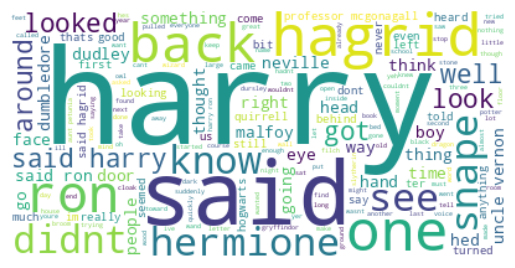

In [25]:
squeezed_words = [word for sublist in cleaned_words for word in sublist]
wordcloud = WordCloud(background_color='white')
wordcloud.generate(' '.join(squeezed_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Spelling Error Correction**

---



**Import library**

In [27]:
from nltk.tokenize import word_tokenize
import string

**Read file**

In [28]:
with open('/content/Vocabulary.txt', 'r', encoding='utf-8') as f:
        vocabulary = set(word.strip() for word in f.readlines())

**levenshtein distance**

In [34]:
def damerau_levenshtein_distance(s1, s2):
    # Create a table to store the results of subproblems
    dp = [[0] * (len(s2) + 1) for _ in range(len(s1) + 1)]

    # Initialize the table
    for i in range(len(s1) + 1):
        dp[i][0] = i
    for j in range(len(s2) + 1):
        dp[0][j] = j

    # Populate the table using dynamic programming
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            if s1[i - 1] == s2[j - 1]:
                cost = 0
            else:
                cost = 1

            dp[i][j] = min(dp[i - 1][j] + 1,          # deletion
                           dp[i][j - 1] + 1,          # insertion
                           dp[i - 1][j - 1] + cost)  # substitution

            # Check for transposition
            if i > 1 and j > 1 and s1[i - 1] == s2[j - 2] and s1[i - 2] == s2[j - 1]:
                dp[i][j] = min(dp[i][j], dp[i - 2][j - 2] + cost)

    # Return the Damerau-Levenshtein distance
    return dp[len(s1)][len(s2)]

**Suggest**

In [35]:
def suggest_corrections(word, vocabulary, split_hyphen=True):
    if split_hyphen and '-' in word:
        parts = word.split('-')
        suggestions = [suggest_corrections(part, vocabulary, split_hyphen=False) for part in parts]
        return '-'.join(suggestions)
    else:
        min_distance = float('inf')
        best_correction = None
        for correct_word in vocabulary:
            distance = damerau_levenshtein_distance(word, correct_word)
            if distance < min_distance:
                min_distance = distance
                best_correction = correct_word
        return best_correction

**Call and Evaluate**

Original Sentence:
> Cross-domain aspect-based sentiment analysis (ABSA) aims to perform various fine-grained sentiment analysis tasks on a target domain by transferring knowledge from a source domain.



Wrong Spelling Sentence:
> rCoss-domin aspenct-base sentimen afalysis (ASA) aams o perorm arious ine-vrained setniment naalysis atsks omn a tarzget omain uy transefrring knoledge frotm a suorce domainh.



In [36]:
sentence = "rCoss-domin aspenct-base sentimen afalysis (ASA) aams o perorm arious ine-vrained setniment naalysis atsks omn a tarzget omain uy transefrring knoledge frotm a suorce domainh."
words = word_tokenize(sentence)

for word in words:
  if word.lower() not in string.punctuation:
    if word.lower() not in vocabulary:
        correction = suggest_corrections(word.lower(), vocabulary)
        print(f"Suggestion for '{word}': {correction}")

Suggestion for 'rCoss-domin': cross-domain
Suggestion for 'aspenct-base': aspect-base
Suggestion for 'sentimen': sentiment
Suggestion for 'afalysis': analysis
Suggestion for 'ASA': asia
Suggestion for 'aams': dams
Suggestion for 'perorm': perform
Suggestion for 'arious': various
Suggestion for 'ine-vrained': inn-brained
Suggestion for 'setniment': sentiment
Suggestion for 'naalysis': analysis
Suggestion for 'atsks': asks
Suggestion for 'omn': own
Suggestion for 'tarzget': target
Suggestion for 'omain': main
Suggestion for 'uy': ay
Suggestion for 'transefrring': transferring
Suggestion for 'knoledge': knowledge
Suggestion for 'frotm': froth
Suggestion for 'suorce': source
Suggestion for 'domainh': domain
